In [1]:
suppressMessages(library(ggView))
suppressMessages(library(MAGeCKFlute))
suppressMessages(library(ggplot2))
suppressMessages(library(ggvenn))
suppressMessages(library(ComplexHeatmap))
options(stringsAsFactors = FALSE)

In [2]:
preds = readRDS("data/Predictions.rds")
preds = preds[order(-preds$MAPD.score), ]
FeatureDat = readRDS("data/Features_Imputed.rds")
Degradability = readRDS("data/Donovan_Degradability.rds")
Degradability$MinLFC = -Degradability$MinLFC
Kinases = rownames(preds)[preds$IsKinase=="Yes"]
PROTAC = rownames(preds)[preds$PROTACdb=="Yes" | preds$PROTACpedia=="Yes"]

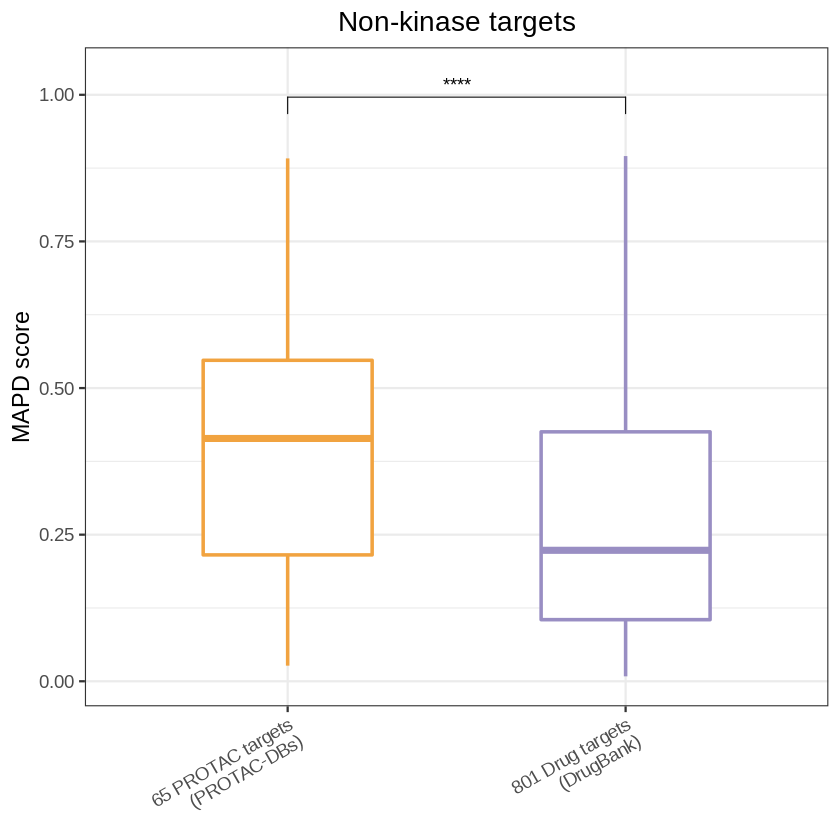

In [3]:
gg = as.data.frame(preds)
gg$Group = NA
gg = gg[gg$IsKinase=="No", ]
gg$Group[gg$DrugBank=="Yes"] = "801 Drug targets\n(DrugBank)"
gg$Group[rownames(gg)%in%PROTAC] = "65 PROTAC targets\n(PROTAC-DBs)"
gg = gg[!is.na(gg$Group), ]
gg$Group = factor(gg$Group, levels = c("65 PROTAC targets\n(PROTAC-DBs)", "801 Drug targets\n(DrugBank)"))
p = BoxView(gg, "Group", "MAPD.score", color = "Group", alpha =1,
            xlab = NULL, ylab = "MAPD score", main = "Non-kinase targets", 
            add.jitter = FALSE, comparisons = list(c("65 PROTAC targets\n(PROTAC-DBs)",
                                                     "801 Drug targets\n(DrugBank)")))
p = p + scale_color_manual(values = c("#f1a340", "#998ec3"))
p = p + theme(axis.text.x = element_text(angle = 30, hjust = 1, vjust = 1))
p = p + ylim(NA, 1.03)
p

`geom_smooth()` using formula 'y ~ x'



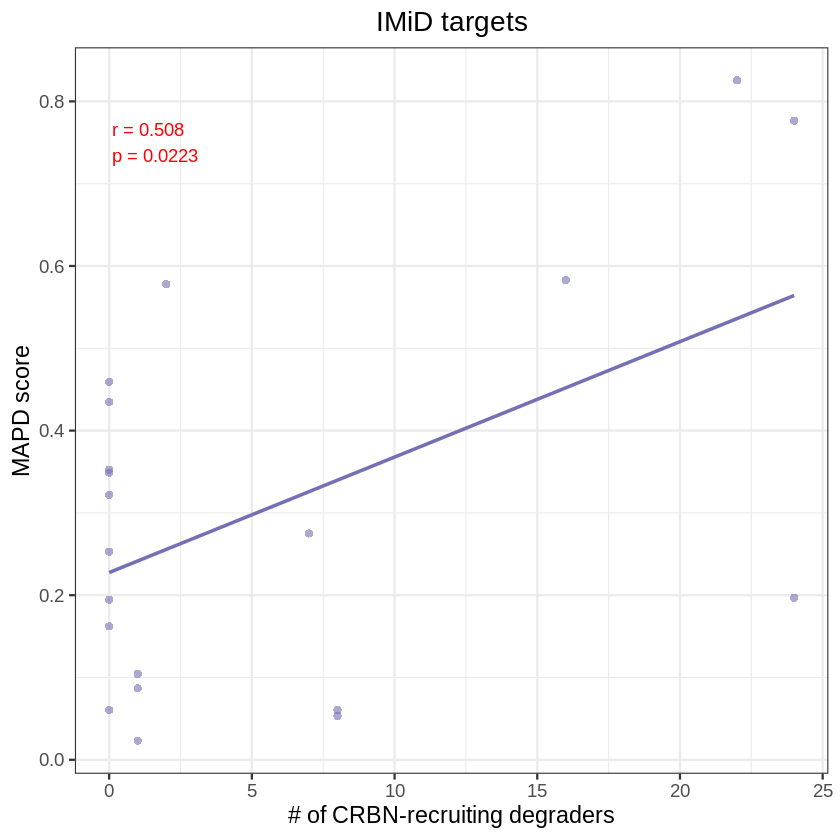

In [4]:
IMiD_targets = c("RNF166", "DTWD1", "E4F1", "IKZF1", "IKZF3", "ZFP91", "ZNF276", "ZNF517", 
                 "ZNF582", "ZNF653", "ZNF654", "ZNF287", "ZNF692", "ZNF787", "ZNF827", "RAB28",
                 "FAM83F", "GZF1", "ZBTB39", "ZNF98", "PATZ1", "ZKSC5", "IKZF2", "IKZF4")
gg1 = as.data.frame(preds[IMiD_targets, ])
gg1$Gene = rownames(gg1)
gg2 = Degradability[, c("Gene", "CRBNDegradeFreq", "CRBNDetectFreq", "MinLFC")]
gg = merge(gg1, gg2, by = "Gene")
gg = gg[gg$CRBNDetectFreq>0, ]

p = ScatterView(gg, "CRBNDegradeFreq", "MAPD.score", label = "Gene", main = "IMiD targets", 
                size = 2, color = "#7570b3")
p = p + geom_smooth(method = "lm", se = FALSE)
p = p + labs(x = "# of CRBN-recruiting degraders", y = "MAPD score")
test = cor.test(gg$CRBNDegradeFreq, gg$MAPD.score)
p = p + annotate("text", x = 0.1, y = 0.75, hjust = 0, color = "red",
                  label = paste0("r = ", round(test$estimate, 3),
                                   "\np = ", format(test$p.value, digits = 3)))
p = p + theme_bw(base_size = 14)
p = p + theme(plot.title = element_text(hjust = 0.5), legend.position = "none")
p

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



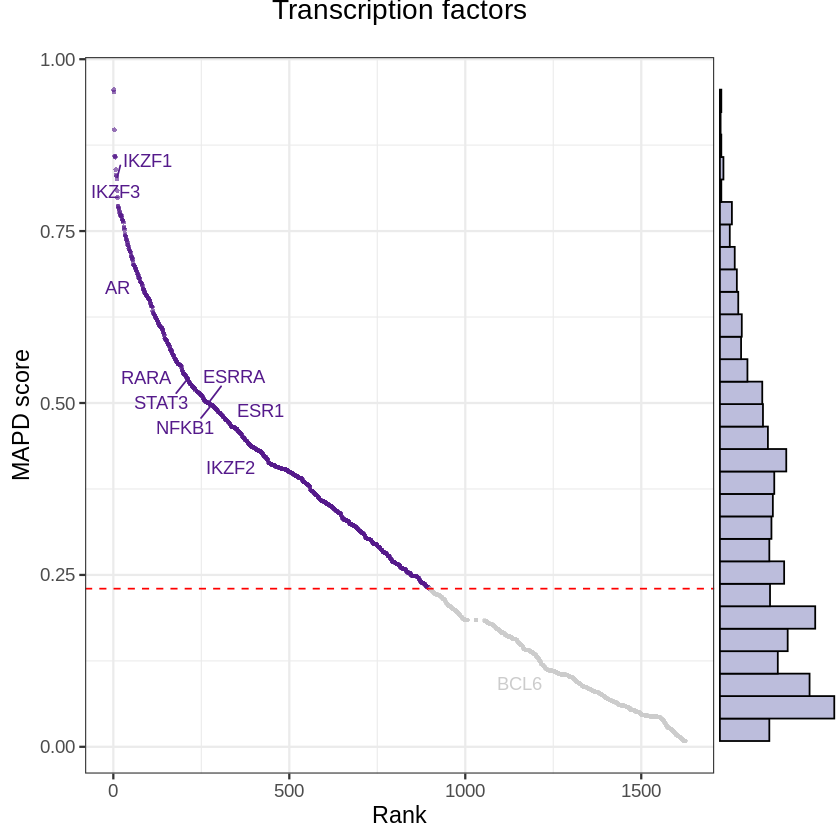

In [5]:
gg = preds[preds$TF=="Yes", ]
gg$Rank = rank(-gg$MAPD.score)
p = ScatterView(gg, "Rank", "MAPD.score", y_cut = 0.23, groups = "top", max.overlaps = Inf,
                ylab = "MAPD score", main = "Transcription factors", top = 0,
                toplabels = c("STAT3", "NFKB1", "IKZF2", "IKZF1", "IKZF3", 
                              setdiff(PROTAC, c("ESRRG", "ZFP91"))))
p = p + geom_hline(yintercept = 0.23, linetype = "dashed", color = "red")
p = p + scale_color_manual(values = c("purple4", "gray80"))
p = p + theme_bw(base_size = 14)
p = p + theme(plot.title = element_text(hjust = 0.5), legend.position = "none")
p = ggExtra::ggMarginal(p, margins = 'y', type="histogram", fill = "#bcbddc")
p

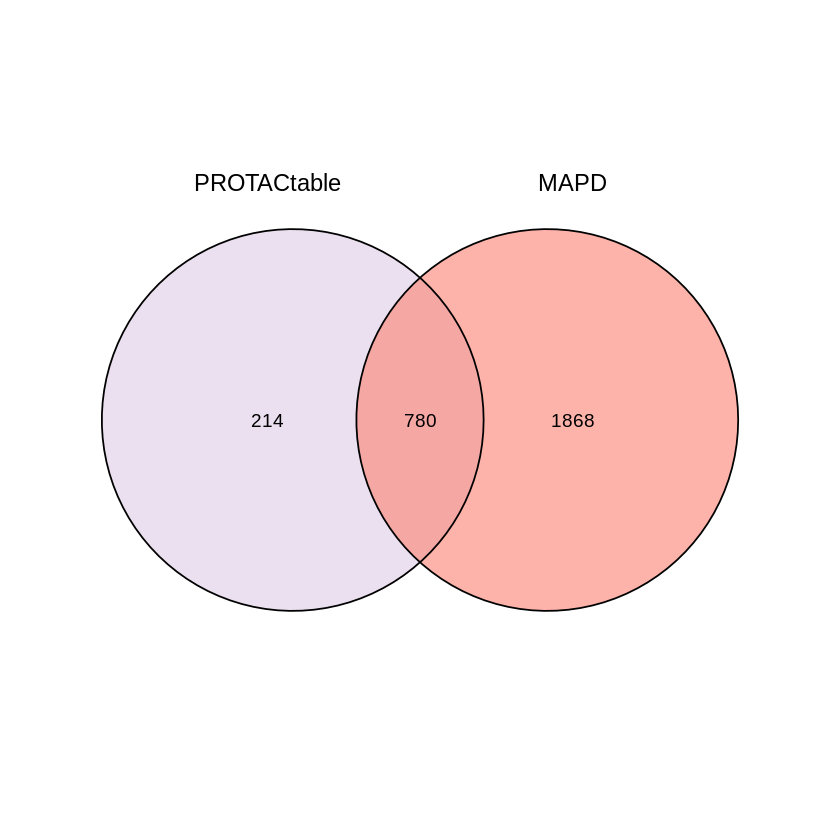

In [6]:
MAPD = rownames(preds)[preds$MAPD.score>=0.2327 & preds$IsKinase=="No"]
PROTACtable = rownames(preds)[preds$PROTACtable=="Yes" & preds$IsKinase=="No"]
ChEMBL = rownames(preds)[preds$ChEMBL=="Yes" & preds$IsKinase=="No"]
SLCABPP = rownames(preds)[preds$Electrophiles=="Yes" & preds$IsKinase=="No"]
DrugBank = rownames(preds)[preds$DrugBank=="Yes" & preds$IsKinase=="No"]
PROTAC_Targets = rownames(preds)[(preds$PROTACdb=="Yes"|preds$PROTACpedia=="Yes") & preds$IsKinase=="No"]
Ligandable = unique(c(ChEMBL, SLCABPP, DrugBank, PROTAC_Targets))
gg = list(PROTACtable = PROTACtable, MAPD = intersect(MAPD, Ligandable))
p = ggvenn(gg, fill_color = c("#decbe4", "#fb8072"), show_percentage = FALSE,
           stroke_size = 0.5, set_name_size = 5, fill_alpha = 0.6)
p

Warning message in if (is.na(fill)) boo2 = TRUE:
“the condition has length > 1 and only the first element will be used”
Warning message in if (fill %in% colnames(gg)) p = p + geom_boxplot(aes_string(fill = fill), :
“the condition has length > 1 and only the first element will be used”


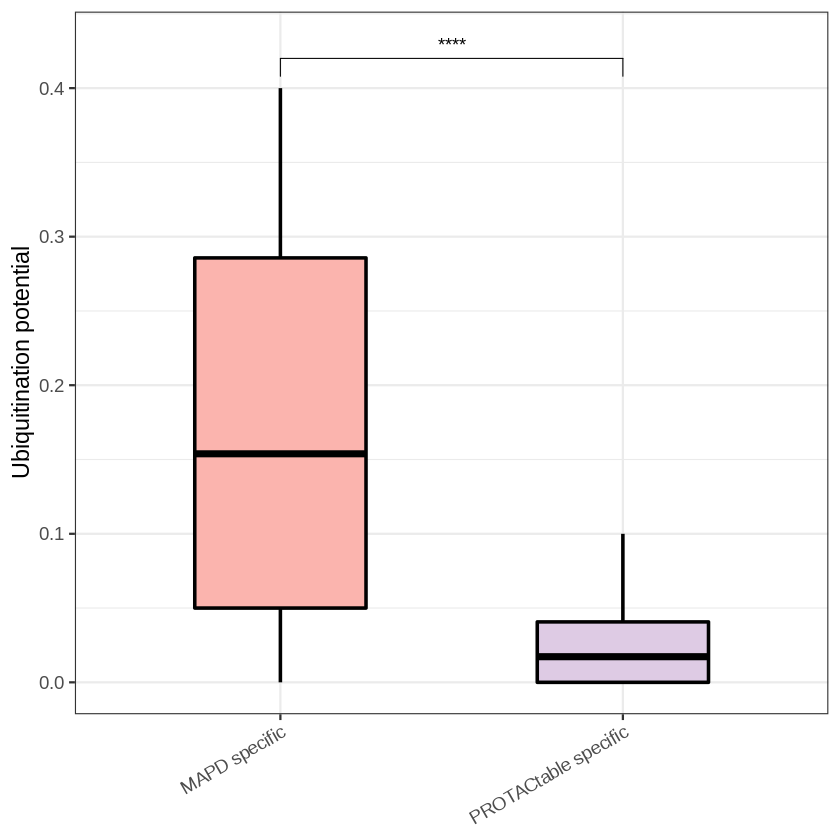

In [7]:
MAPD = intersect(MAPD, Ligandable)
MAPD_specific = setdiff(MAPD, PROTACtable)
PROTACtable_specific = setdiff(PROTACtable, MAPD)
gg = FeatureDat[c(MAPD_specific, PROTACtable_specific), ]
gg$Group = "MAPD specific"
gg$Group[rownames(gg)%in%PROTACtable_specific] = "PROTACtable specific"
gg = gg[gg$Detectability>0.1, ]
gg$Ubiquitination_2[gg$Ubiquitination_2>0.4] = 0.4
p = BoxView(gg, "Group", "Ubiquitination_2", comparisons = list(c("MAPD specific", "PROTACtable specific")),
            fill = c("#fbb4ae", "#decbe4"), xlab = NULL, ylab = "Ubiquitination potential")
p = p + theme(axis.text.x = element_text(angle = 30, hjust = 1, vjust = 1))
p = p + ylim(NA, 0.43)
p

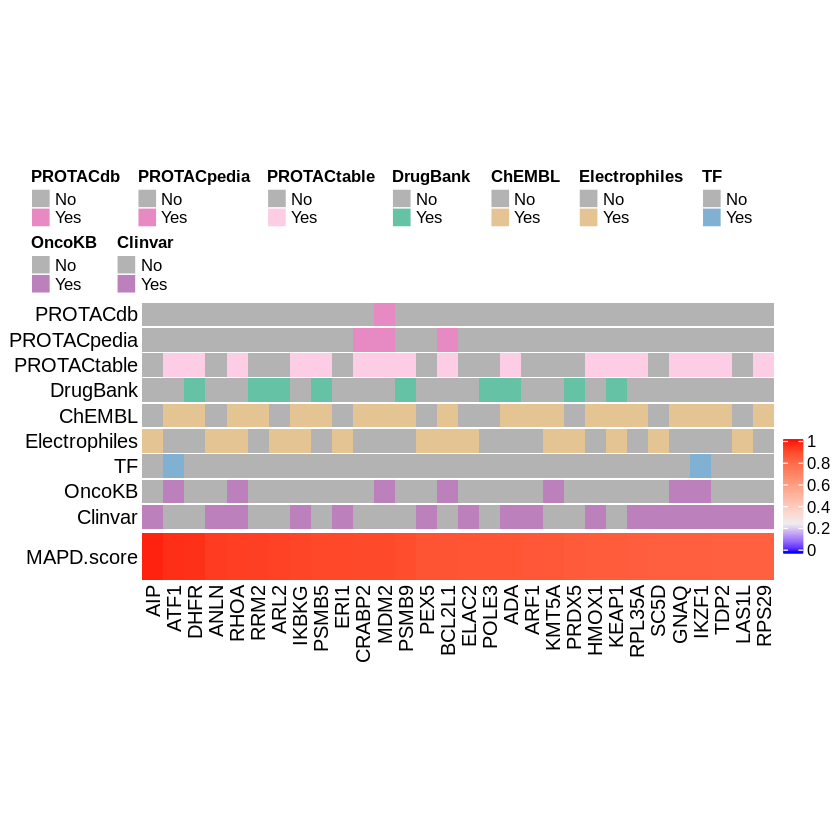

In [8]:
idx1 = preds$DrugBank=="Yes" | preds$OncoKB=="Yes" | preds$Clinvar=="Yes" | preds$PROTACdb=="Yes" | preds$PROTACpedia=="Yes"
idx2 = preds$PROTACdb=="Yes" | preds$PROTACpedia=="Yes" | preds$DrugBank=="Yes" | preds$ChEMBL=="Yes" | preds$Electrophiles=="Yes" 
KinGG = preds[preds$IsKinase=="No" & (idx1&idx2), ][1:30, -c(2:7,10,18)]

col = circlize::colorRamp2(c(0, 0.25, 1), c("blue", "#EEEEEE", "red"))
ha = HeatmapAnnotation(df = KinGG[,-1], annotation_name_side = "left",
                       col = list("PROTACdb" = c("Yes" = "#e78ac3", "No" = "#b3b3b3"),
                                  "PROTACpedia" = c("Yes" = "#e78ac3", "No" = "#b3b3b3"),
                                  "Multi.kinase.degrader" = c("Yes" = "#ff7f00", "No" = "#b3b3b3"),
                                  "PROTACtable" = c("Yes" =  "#fccde5", "No" = "#b3b3b3"),
                                  "DrugBank" = c("Yes" =  "#66c2a5", "No" = "#b3b3b3"),
                                  "ChEMBL" = c("Yes" =  "#e5c494", "No" = "#b3b3b3"),
                                  "Electrophiles" = c("Yes" =  "#e5c494", "No" = "#b3b3b3"),
                                  "TF" = c("Yes" =  "#80b1d3", "No" = "#b3b3b3"),
                                  "OncoKB" = c("Yes" =  "#bc80bd", "No" = "#b3b3b3"),
                                  "Clinvar" = c("Yes" =  "#bc80bd", "No" = "#b3b3b3")))
p = Heatmap(t(KinGG[,1,drop=FALSE]), col = col, name = " ", row_names_side = "left", 
            cluster_columns = FALSE, top_annotation = ha, height = unit(1, "cm"))
draw(p, annotation_legend_side = "top")